In [ ]:

import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch
from keras.preprocessing.text import Tokenizer
#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 
from keras.utils import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [ ]:
embed_size = 512 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [ ]:
data= pd.read_csv("/content/train.csv")

In [ ]:
data = data[pd.notnull(data['sentence'])]

In [ ]:
data['len'] = data['sentence'].apply(lambda s : len(s))

In [ ]:
data.len.quantile(0.98)

181.0

<Axes: ylabel='Frequency'>

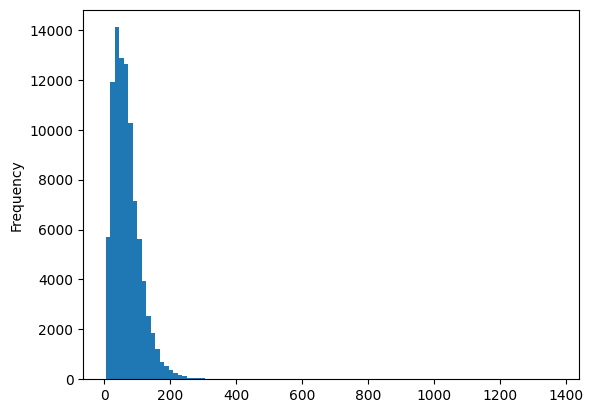

In [ ]:
data['len'].plot.hist(bins=100)

In [ ]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [ ]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [ ]:
# lower the text
data["sentence"] = data["sentence"].apply(lambda x: x.lower())

# Clean the text
data["sentence"] = data["sentence"].apply(lambda x: clean_text(x))

# Clean numbers
data["sentence"] = data["sentence"].apply(lambda x: clean_numbers(x))

# Clean Contractions
data["sentence"] = data["sentence"].apply(lambda x: replace_contractions(x))

In [ ]:
data['sentence'] = data['sentence'].str.replace('[^\w\s]', ' ')


<ipython-input-121-bd936af8f7cd>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['sentence'] = data['sentence'].str.replace('[^\w\s]', ' ')


In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)
data['sentence'] = data['sentence'].apply(lemmatize_words)



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import re
data['sentence'] = data['sentence'].apply(lambda x: x.strip())
data['sentence'] = data['sentence'].apply(lambda x: re.sub(" +", " ", x))

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
train_data, val_data = train_test_split(data, test_size=0.20)
train_data=data

In [ ]:
print("Train shape : ",train_data.shape)
print("Test shape : ",val_data.shape)

Train shape :  (92228, 4)
Test shape :  (18446, 4)


In [ ]:
train_X=train_data['sentence']
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))

In [ ]:
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(val_data['sentence'])

In [ ]:
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


In [ ]:
val_data['neu']=np.zeros(len(val_data))
val_data['neg']=np.zeros(len(val_data))
val_data['pos']=np.zeros(len(val_data))
train_data['neu']=np.zeros(len(train_data))
train_data['neg']=np.zeros(len(train_data))
train_data['pos']=np.zeros(len(train_data))
train_data['neu']=train_data['gold_label']==0
train_data['neg']=train_data['gold_label']==-1
train_data['pos']=train_data['gold_label']==1
train_data['neu']=train_data['neu'].astype(float)
train_data['neg']=train_data['neg'].astype(float)
train_data['pos']=train_data['pos'].astype(float)
val_data['neu']=val_data['gold_label']==0
val_data['neg']=val_data['gold_label']==-1
val_data['pos']=val_data['gold_label']==1
val_data['neu']=val_data['neu'].astype(float)
val_data['neg']=val_data['neg'].astype(float)
val_data['pos']=val_data['pos'].astype(float)

In [ ]:
train_y = (train_data[['neg','neu','pos']].values)
test_y = (val_data[['neg','neu','pos']].values)

In [ ]:
class LSTM(nn.Module):
    
    def _init_(self, hidden_size, num_layers, n_classes, dropout=0.1, pretrained_embeddings=None):
        super(LSTM, self)._init_()
        self.embedding = nn.Embedding(max_features, embed_size)
        self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        output = self.dropout(output)
        output = torch.mean(output, dim=1)
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [ ]:
n_epochs = 3
model = LSTM(256, 2, 3)
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.float).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.float).cuda()

In [ ]:
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

In [ ]:
train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch.float())
        #print(y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),3))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch.float()).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y.argmax(axis=1))/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<ipython-input-136-b53db76aedae>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/2 	 loss=0.5225 	 val_loss=0.4243  	 val_acc=0.7015  	 time=37.32s
Epoch 2/2 	 loss=0.4168 	 val_loss=0.3482  	 val_acc=0.7750  	 time=36.83s


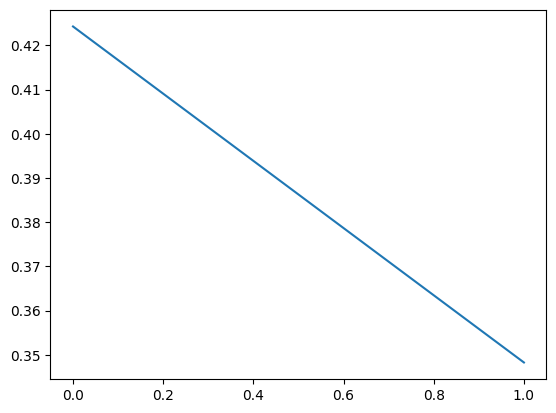

In [ ]:
plt.plot(valid_loss)

In [ ]:
loss_fn(torch.tensor([1,5.0,0]),torch.tensor([1.0,0,0]))

tensor(2.0044)

In [ ]:
torch.empty(3, dtype=torch.long).random_(5)

tensor([4, 4, 3])

In [ ]:
data= pd.read_csv("train.csv")

In [ ]:
# lower the text
data["sentence"] = data["sentence"].apply(lambda x: x.lower())

# Clean the text
data["sentence"] = data["sentence"].apply(lambda x: clean_text(x))

# Clean numbers
data["sentence"] = data["sentence"].apply(lambda x: clean_numbers(x))

# Clean Contractions
data["sentence"] = data["sentence"].apply(lambda x: replace_contractions(x))
data['sentence'] = data['sentence'].str.replace('[^\w\s]', ' ')
data['sentence'] = data['sentence'].apply(lemmatize_words)
test_X = tokenizer.texts_to_sequences(data['sentence'])
test_X = pad_sequences(test_X, maxlen=maxlen)

<ipython-input-141-2e5c25085c8d>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  data['sentence'] = data['sentence'].str.replace('[^\w\s]', ' ')


In [ ]:
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
valid = torch.utils.data.TensorDataset(x_cv)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=64, shuffle=False)

In [ ]:
model.eval()
y_hat=[]
batch_size=64
val_preds = np.zeros((len(x_cv),3))
for i, (x_batch) in enumerate(valid_loader):
        #print(x_batch[0])
        y_pred = model(x_batch[0]).detach()
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
y_hat=(val_preds.argmax(axis=1))

<ipython-input-143-2c4aedfbe086>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


In [ ]:
k=0
with open('/content/answer.txt', 'w') as f:
    for i in (y_hat-1):
        f.write(str(i))
        k+=1
        if k==4855:
          break
        f.write('\n')


In [ ]:
len(data)==4855

True